FGSM on a neat

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import random
import math
import time
import sys
import os

sys.path.append(os.path.abspath("../neat"))

from cppn import *
from genome import *
from speciation import *

random.seed(42)
torch.manual_seed(42)

In [9]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

data_tensor = torch.tensor(digits.data, dtype=torch.float32)
data_tensor = torch.tensor(digits.data / 16.0, dtype=torch.float32) # Normalize for neat
target_tensor = torch.tensor(digits.target, dtype=torch.long)

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    data_tensor, target_tensor, test_size=0.2, random_state=42, shuffle=True
)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Batch is the full size because there is no backpropogation
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [36]:
# Init stuff

# Hyperparameters
input_dim = 8*8
output_dim = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = NN(input_dim, output_dim).to(device)
model.load_state_dict(torch.load('../models/sklearn_digits_100pop_2000epoch_real95.83.pth'))

<All keys matched successfully>

In [37]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)  # logits
        predicted = torch.argmax(outputs, dim=1)  # class indices

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 5.36%


In [11]:
import matplotlib.pyplot as plt

def plot_img(img, label=None):
    plt.figure(figsize=(2, 2))
    plt.imshow(img, cmap='gray_r')
    if label is not None:
        plt.title(f"Label: {label}")
        
    plt.tight_layout()
    plt.show()

In [12]:
# FGSM

# new image = original image + perturbation scalar * neg (gradient with respect to the loss)

def FGSM(img, target, scalar=.01):
    img = img.clone().view(1, -1).detach().requires_grad_(True)  # Input usually doesnt require grad
    y = model(img)
    
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(y, target.view(1))
    
    loss.backward()
    grad = img.grad.data
    signed_grad = grad.sign()
    mod_img = img + (scalar * signed_grad)
    return mod_img.detach()

In [31]:
target_tensor[1232].view(1)

tensor([2])

In [32]:
torch.argmax(model(data_tensor[1232].view(1, -1)))

tensor(9)

In [26]:
d=483

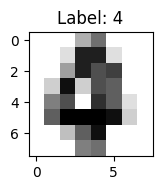

RuntimeError: shape '[8, 8]' is invalid for input of size 10

In [29]:
plot_img(data_tensor[d].view(8, 8), target_tensor[d])

modified = FGSM(data_tensor[d], target_tensor[344])
# modified.shape
modified_label = torch.argmax(model(modified))

plot_img(modified.view(8, 8), modified_label)